# This notebook is designed to explore the data

## Imports

In [2]:
# Import dependencies
import pandas as pd
import numpy as np
import os,sys
import json
import re
import matplotlib.pyplot as plt
from datetime import date, datetime
import dateparser
from pprint import pprint

DATA_DIR = "data"

## Small Helper Functions

In [3]:
def to_date(d):
    return datetime.strptime(d, "%Y-%m-%d").date()

def to_time(t):
    return datetime.strptime(t[:8], "%H:%M:%S").time()

## Load clean data and county data

In [4]:
events = pd.read_csv(os.path.join(DATA_DIR, "Events_USA_2010.tsv"), delimiter="\t")
events = events.where((pd.notnull(events)), None)
with open(os.path.join(DATA_DIR, "county_data.json"), 'r') as _:
    county_data = json.load(_)

## Plot dates/times of shootings from the clean data

In [79]:
# Collect data on dates and times of shootings
# Prefer Fine Time to Coarse Time if the record has it
event_dates = []
event_times = []
for index, event in events.iterrows():
    event_dates.append(to_date(event["Date"]))
    if event["Fine Time"]:
        event_times.append(to_time(event["Fine Time"]))
    elif event["Coarse Time"]:
        event_times.append(to_time(event["Coarse Time"]))
    else:
        event_times.append(None)

In [80]:
# Create bar charts of # events by year and # events by time of day
num_events_by_year = []
years = range(2010, 2018)
for year in years:
    start = date(year, 1, 1)
    end = date(year, 12,31)
    events_in_year = len([d for d in event_dates if d >= start and d <= end])
    num_events_by_year.append(events_in_year)
    
num_events_by_tod = []
time_ranges = [(0, 6), (6, 12), (12, 18), (18, 0)]
for tr in time_ranges:
    start = datetime.now().replace(hour=tr[0], minute=0, second=0, microsecond=0).time()
    end = datetime.now().replace(hour=(tr[1]-1) % 24, minute=59, second=59, microsecond=0).time()
    events_in_time_range = len([t for t in event_times if t and t >= start and t <= end])
    num_events_by_tod.append(events_in_time_range)
    
num_empty_times = len([t for t in event_times if not t])

print("%d total events" % len(event_times))
print("%d events with no time" % num_empty_times)

2966 total events
638 events with no time


Text(0,0.5,'Number of Gun Violence Events')

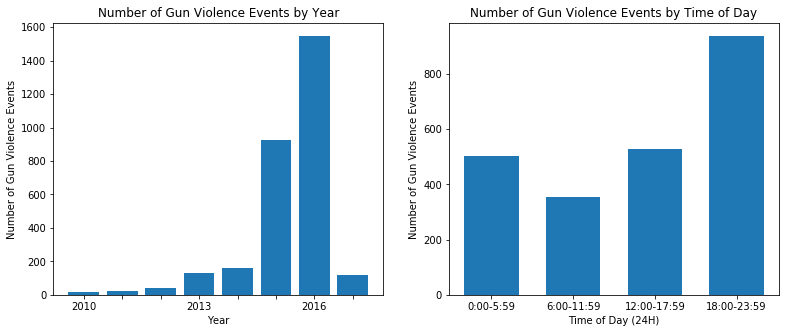

In [81]:
# Show the graphs
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].bar(years, num_events_by_year, tick_label=[str(year) if i % 3 == 0 else "" for i, year in enumerate(years)])
ax[0].set_title("Number of Gun Violence Events by Year")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Number of Gun Violence Events")

ax[1].bar([tr[0] for tr in time_ranges], num_events_by_tod, width=4,
        tick_label=["0:00-5:59", "6:00-11:59", "12:00-17:59", "18:00-23:59"])
ax[1].set_title("Number of Gun Violence Events by Time of Day")
ax[1].set_xlabel("Time of Day (24H)")
ax[1].set_ylabel("Number of Gun Violence Events")

The first graph indicates that our data is very heavily biased towards more recent events, and specifically 2016. No other data source cites a climb in gun violence of 800% from 2014 to 2016, so this bias is likely from more recent reports being available, or the data collection process.

The second graph indicates that between 6PM and midnight is the most likely time for gun violence to occur. It is roughly twice as likely in that time range than in any other.

## Determine how many counties are represented in our data
There are 3007 counties in the United States

In [87]:
counties = {}
for index, event in events.iterrows():
    state = event["StateFP"]
    county = event["CountyFP"]
    if state not in counties:
        counties[state] = {}
    counties[state][county] = counties[state].get(county, 0) + 1
num_counties = sum([len(c) for i,c in counties.items()])
print(num_counties)

877
